In [1]:
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import uniform,norm,t,binom,expon,chi2,gamma,poisson,beta,dirichlet
from scipy.stats import multivariate_normal as multi_norm
from scipy.optimize import brentq
from scipy.special import perm,comb
import time
import pandas as pd

**8.1**

In [2]:
def increasing(theta):
    f=lambda x: x**theta
    X=uniform.rvs(size=10000)
    print(np.corrcoef(f(X),f(1-X))[0,1])

In [3]:
increasing(1)
increasing(2)
increasing(4)
increasing(8)
increasing(16)
increasing(32)
increasing(64)
increasing(128)

-1.0
-0.8766177830520633
-0.5411912362818592
-0.26412446653995114
-0.13068298078211255
-0.06285077847655224
-0.03278302005303436
-0.01773742660676264


**8.4**

In [4]:
f=lambda x: 100*(x>0.9)*(x<=0.91)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'<',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

48.73116863999999 < 49.71990590999999
1.0041 0.009970044292278747
0.9972 0.009885908371009717


In [5]:
f=lambda x: 100*(x>0.45)*(x<=0.55)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'>',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

897.5750819100003 > 0.0
9.9697 0.029959557438486974
9.9534 0.04233839459497726


**8.7**

In [6]:
def BB_params(m,s):
    u=np.int64(-1*np.ones(m))
    v=np.int64(-1*np.ones(m))
    a=np.zeros(m)
    b=np.zeros(m)
    w=np.zeros(m)
    for j in range(m):
        sub=s[:j][s[:j]<s[j]]
        u[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.max(sub))
        sub=s[:j][s[:j]>s[j]]
        v[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.min(sub))
        if u[j]>=0 and v[j]>=0:
            l=s[u[j]]
            r=s[v[j]]
            a[j]=(r-s[j])/(r-l)
            b[j]=(s[j]-l)/(r-l)
            w[j]=np.sqrt((s[j]-l)*(r-s[j])/(r-l))
        elif u[j]>=0:
            l=s[u[j]]
            a[j]=1
            w[j]=np.sqrt(s[j]-l)
        elif v[j]>=0:
            r=s[v[j]]
            b[j]=s[j]/r
            w[j]=np.sqrt(s[j]*(r-s[j])/r)
        else:
            w[j]=np.sqrt(s[j])
            
    return u,v,a,b,w

def conBMviaBB(m,s,z,params,Bint):
    u,v,a,b,w=params
    B=np.zeros(m)
    k=len(Bint)
    B[:k]=Bint
    for j in range(k,m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

def BMviaBB(m,s,z,params):
    u,v,a,b,w=params
    B=np.zeros(m)
    for j in range(m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

In [7]:
def straBM(M,N,i,draw):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    if draw:
        plt.plot(np.sort(t),B)
        
    return B

def straGenBM(M,N,i,draw,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    X=delta*np.sort(T*t)+sigma*np.sqrt(T)*B
    if draw:
        plt.plot(np.sort(T*t),X)
        
    return X

def straGBM(M,N,i,draw,S0,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    S=S0*np.exp((delta-sigma**2/2)*np.sort(T*t)+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(np.sort(T*t),S)
        
    return S

def GBM(M,N,draw,S0,delta,sigma,T):
    t=np.linspace(0,1,M+1)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=BMviaBB(M+1,t,Z,params)
    S=S0*np.exp((delta-sigma**2/2)*T*t+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(T*t,S)
        
    return S

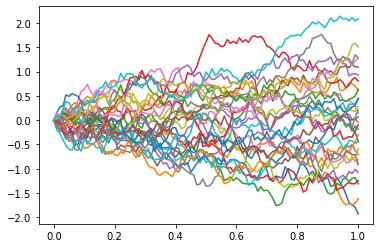

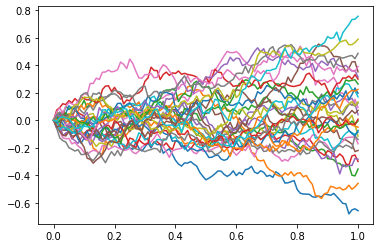

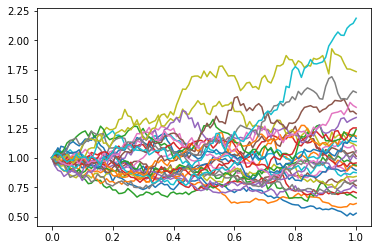

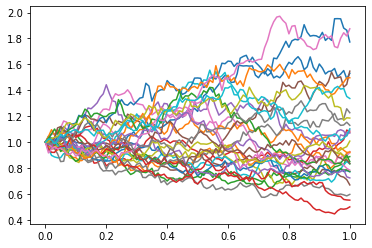

In [8]:
M=100
N=30
draw=True
for i in range(N):
    straBM(M,N,i+1,draw)
    
plt.show()

delta=0.05
sigma=0.3
T=1
for i in range(N):
    straGenBM(M,N,i+1,draw,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    GBM(M,N,draw,S0,delta,sigma,T)
    
plt.show()

In [9]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.4576761478777289 0.004374508279019986
7.118597984313965


In [10]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.4590822414768364 0.004378799676055045
4.364670991897583


**8.9**